In [34]:
import numpy as np
import pandas as pd
import sympy as S
from scipy import stats

import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline

In [35]:
mpl.style.use('seaborn-darkgrid')
mpl.rcParams.update({'font.size': 18})

In [36]:
pd.options.display.max_rows = 10

# Decision Trees

A decision tree is the easiest classifer to understand, interpret, and explain.
A decision tree is constructed by recursively splitting the data set into a
sequence of subsets based on if-then questions.  The training set consists of
pairs $(\mathbf{x},y)$ where $\mathbf{x}\in \mathbb{R}^d$ where $d$ is the
number of features available and where $y$ is the corresponding label. The
learning method splits the training set into groups based on $\mathbf{x}$ while
attempting to keep the assignments in each group as uniform as possible. In
order to
do this, the learning method must pick a feature and an associated threshold for
that feature upon which to
divide the data.  This is tricky to explain in words, but easy to see with
an example. First, let's set up the Scikit-learn classifer,

In [2]:
from numpy import ma
np.random.seed(12345678)

In [3]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()

Let's also create some example data,

In [4]:
import numpy as np
M = np.fromfunction(lambda i, j: j >= 2, (4, 4)).astype(int)
print(M)

[[0 0 1 1]
 [0 0 1 1]
 [0 0 1 1]
 [0 0 1 1]]


**Programming Tip.**

The `fromfunction` creates Numpy arrays using the indicies as inputs
to a function whose value is the corresponding array entry.



We want to classify the elements of the matrix based on their
respective positions in the matrix. By just looking at the matrix, the
classification is pretty simple --- classify as `0` for any positions in the
first two columns of the matrix, and classify `1` otherwise.  Let's walk
through this formally and see if this solution emerges from the decision
tree.  The values of the array are the labels for the training set and the
indicies of those values are the elements of $\mathbf{x}$. Specifically, the
training set has $\mathcal{X} = \left\{(i,j)\right\}$ and
$\mathcal{Y}=\left\{0,1\right\}$ Now, let's extract those elements and construct
the training set.

In [5]:
np.where(M == 0)

(array([0, 0, 1, 1, 2, 2, 3, 3]), array([0, 1, 0, 1, 0, 1, 0, 1]))

In [6]:
i, j = np.where(M == 0)
x = np.vstack([i, j]).T  # build nsamp by nfeatures
y = j.reshape(-1, 1) * 0  # 0 elements
print(x)
print(y)

[[0 0]
 [0 1]
 [1 0]
 [1 1]
 [2 0]
 [2 1]
 [3 0]
 [3 1]]
[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]


Thus, the elements of `x` are the two-dimensional indicies of the
values of `y`. For example, `M[x[0,0],x[0,1]]=y[0,0]`. Likewise,
to complete the training set, we just need to stack the rest of the data to
cover
all the cases,

In [7]:
i, j = np.where(M == 1)
x = np.vstack([np.vstack([i, j]).T, x])  # build nsamp x nfeatures
y = np.vstack([j.reshape(-1, 1) * 0 + 1, y])  # 1 elements

In [13]:
np.hstack([x,y])

array([[0, 2, 1],
       [0, 3, 1],
       [1, 2, 1],
       [1, 3, 1],
       [2, 2, 1],
       [2, 3, 1],
       [3, 2, 1],
       [3, 3, 1],
       [0, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [1, 1, 0],
       [2, 0, 0],
       [2, 1, 0],
       [3, 0, 0],
       [3, 1, 0]])

With all that established, all we have to do is train the classifer,

In [14]:
clf.fit(x,y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

To evaluate how the classifer performed, we can report the score,

In [15]:
clf.score(x,y)

1.0

In [18]:
!pip install pydotplus

    100% |████████████████████████████████| 286kB 4.4MB/s ta 0:00:01
  Running setup.py bdist_wheel for pydotplus ... done
  Stored in directory: /home/hvribeiro/.cache/pip/wheels/35/7b/ab/66fb7b2ac1f6df87475b09dc48e707b6e0de80a6d8444e3628
Successfully built pydotplus
You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [20]:
!pip install graphviz

You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [ ]:
!sudo apt-get install graphviz

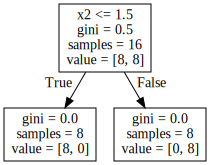

In [24]:
from IPython.display import SVG
from graphviz import Source
graph = Source( tree.export_graphviz(clf, out_file=None, feature_names=['x1','x2']))
SVG(graph.pipe(format='svg'))

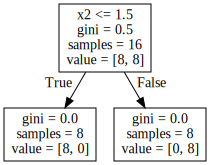

In [23]:
from graphviz import Source
Source( tree.export_graphviz(clf, out_file=None, feature_names=['x1','x2']))

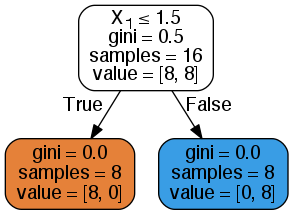

In [25]:
from sklearn.externals.six import StringIO
from IPython.display import Image  
import pydotplus

dot_data = StringIO()

tree.export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

For this classifer, the *score* is the accuracy, which is
defined as the ratio of the sum of the true-positive ($TP$) and
true-negatives ($TN$) divided by the sum of all the terms, including
the false terms,

$$
\texttt{accuracy}=\frac{TP+TN}{TP+TN+FN+FP}
$$

In this case, the classifier gets every point correctly, so
$FN=FP=0$. On a related note, two other common names from information retrieval
theory are  *recall* (a.k.a. sensitivity) and *precision* (a.k.a. positive
predictive value, $TP/(TP+FP)$).  We can visualize this tree in
[Figure](#fig:example_tree_001). The Gini coefficients (a.k.a. categorical
variance)
in the figure are a measure of the purity of each so-determined class. This
coefficient is defined as,

<!-- dom:FIGURE: [fig-machine_learning/example_tree_001.png, width=500 frac=0.5]
Example decision tree. The `Gini` coefficient in each branch measures the purity
of the partition in each node.  The `samples` item in the box shows the number
of items in the corresponding node in the decision tree. <div
id="fig:example_tree_001"></div> -->
<!-- begin figure -->
<div id="fig:example_tree_001"></div>

<p>Example decision tree. The <code>Gini</code> coefficient in each branch
measures the purity of the partition in each node.  The <code>samples</code>
item in the box shows the number of items in the corresponding node in the
decision tree.</p>
<img src="fig-machine_learning/example_tree_001.png" width=500>

<!-- end figure -->

$$
\texttt{Gini}_m = \sum_k p_{m,k}(1-p_{m,k})
$$

where

$$
p_{m,k} = \frac{1}{N_m} \sum_{x_i\in R_m} I(y_i=k)
$$

which is the proportion of observations labeled $k$ in the $m^{th}$
node and $I(\cdot)$ is the usual indicator function. Note that the maximum value
of
the Gini coefficient is $\max{\texttt{Gini}_{m}}=1-1/m$. For our simple
example, half of the sixteen samples are in category `0` and the other half are
in the `1` category.  Using the notation above, the top box corresponds to the
$0^{th}$ node, so $p_{0,0} =1/2 = p_{0,1}$. Then, $\texttt{Gini}_0=0.5$. The
next layer of nodes in [Figure](#fig:example_tree_001) is determined by
whether or not the second dimension of the $\mathbf{x}$ data is greater than
`1.5`. The Gini coefficients for each of these child nodes is zero because
after the prior split, each subsequent category is pure. The `value` list in
each of the nodes shows the distribution of elements in each category at each
node.

To make this example more interesting, we can contaminate the data slightly,

In [26]:
M[1, 0] = 1  # put in different class
print(M)  # now contaminated

[[0 0 1 1]
 [1 0 1 1]
 [0 0 1 1]
 [0 0 1 1]]


Now we have a `1` entry in the previously
pure first column's second  row.

In [27]:
i, j = np.where(M == 0)
x = np.vstack([i, j]).T
y = j.reshape(-1, 1) * 0
i, j = np.where(M == 1)
x = np.vstack([np.vstack([i, j]).T, x])
y = np.vstack([j.reshape(-1, 1) * 0 + 1, y])

np.hstack([x,y])

array([[0, 2, 1],
       [0, 3, 1],
       [1, 0, 1],
       [1, 2, 1],
       [1, 3, 1],
       [2, 2, 1],
       [2, 3, 1],
       [3, 2, 1],
       [3, 3, 1],
       [0, 0, 0],
       [0, 1, 0],
       [1, 1, 0],
       [2, 0, 0],
       [2, 1, 0],
       [3, 0, 0],
       [3, 1, 0]])

In [28]:
clf.fit(x, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

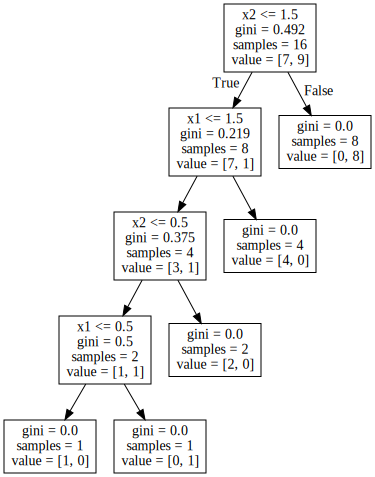

In [29]:
Source( tree.export_graphviz(clf, out_file=None, feature_names=['x1','x2']))

The result is shown
in [Figure](#fig:example_tree_002). Note the tree has grown
significantly due to this one change! The $0^{th}$ node has the
following parameters, $p_{0,0} =7/16$ and $p_{0,1}=9/16$. This makes
the Gini coefficient for the $0^{th}$ node equal to
$\frac{7}{16}\left(1-\frac{7}{16}\right)+\frac{9}{16}(1-\frac{9}{16})
= 0.492$.  As before, the root node splits on $X[1] \leq 1.5$. Let's
see if we can reconstruct the succeeding layer of nodes manually, as
in the following,

In [30]:
y[x[:,1]>1.5] # first node on the right

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

This obviously has a zero Gini coefficient. Likewise, the node on the
left contains the following,

In [31]:
y[x[:,1]<=1.5] # first node on the left

array([[1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

The Gini coefficient in this case is computed as
`(1/8)*(1-1/8)+(7/8)*(1-7/8)=0.21875`. This node splits based on `X[1]<0.5`.
The child node to the right derives from the following equivalent logic,

In [13]:
np.logical_and(x[:,1]<=1.5,x[:,1]>0.5)

array([False, False, False, False, False, False, False, False, False,
       False,  True,  True, False,  True, False,  True], dtype=bool)

with corresponding classes,

In [14]:
y[np.logical_and(x[:,1]<=1.5,x[:,1]>0.5)]

array([[0],
       [0],
       [0],
       [0]])

**Programming Tip.**

The  `logical_and` in Numpy provides element-wise logical conjuction. It is not
possible to accomplish this with something like `0.5< x[:,1] <=1.5` because
of the way Python parses this syntax.



<!-- dom:FIGURE: [fig-machine_learning/example_tree_002.png, width=500
frac=0.65] Decision tree for contaminated data. Note that just one change in the
training data caused the tree to grow five times as large as before! <div
id="fig:example_tree_002"></div> -->
<!-- begin figure -->
<div id="fig:example_tree_002"></div>

<p>Decision tree for contaminated data. Note that just one change in the
training data caused the tree to grow five times as large as before!</p>
<img src="fig-machine_learning/example_tree_002.png" width=500>

<!-- end figure -->


Notice that for this example as well as for the previous one, the decision tree
was exactly able memorize (overfit) the data with perfect accuracy. From our
discussion of machine learning theory, this is an indication potential problems
in generalization.


The key step in building the decision tree is to come up with the
initial split. There are the number of algorithms that can build
decision trees based on different criteria, but the general idea is to
control the information *entropy* as the tree is developed.  In
practical terms, this means that the algorithms attempt to build trees
that are not excessively deep. It is well-established that this is a
very hard problem to solve completely and there are many approaches to
it.  This is because the algorithms must make global decisions at each
node of the tree using the local data available up to that point.

In [32]:
ma.masked_array(x[:,1],y==1)

masked_array(data=[--, --, --, --, --, --, --, --, --, 0, 1, 1, 0, 1, 0,
                   1],
             mask=[ True,  True,  True,  True,  True,  True,  True,  True,
                    True, False, False, False, False, False, False, False],
       fill_value=999999)

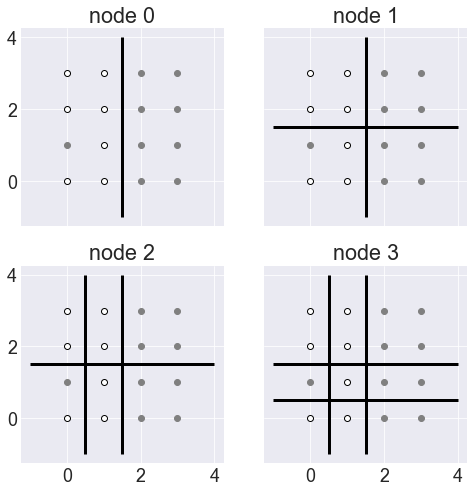

In [40]:
clf.fit(x, y)
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True,figsize=(8,8))
# ax = axs[0, 0]
# ax.set_aspect(1)
# ax.axis((-1, 4, -1, 4))
# ax.invert_yaxis()

# same background all on axes
for ax in axs.flat:
    ax.plot(
        ma.masked_array(x[:, 1], y == 1),
        ma.masked_array(x[:, 0], y == 1),
        'ow',
        mec='k')
    ax.plot(
        ma.masked_array(x[:, 1], y == 0),
        ma.masked_array(x[:, 0], y == 0),
        'o',
        color='gray')

lines = {'h': [], 'v': []}
nc = 0
for i, j, ax in zip(clf.tree_.feature, clf.tree_.threshold, axs.flat):
    ax.set_title('node %d' % (nc))
    nc += 1
    if i == 0:
        lines['h'].append(j)
    elif i == 1: 
        lines['v'].append(j)

    for l in lines['v']:
        ax.vlines(l, -1, 4, lw=3)
    for l in lines['h']:
        ax.hlines(l, -1, 4, lw=3)

<!-- dom:FIGURE: [fig-machine_learning/example_tree_003.png, width=500
frac=0.85]  The decision tree divides the training set into regions by splitting
successively along each dimension until each region is as pure as possible. <div
id="fig:example_tree_003"></div> -->
<!-- begin figure -->
<div id="fig:example_tree_003"></div>

<p>The decision tree divides the training set into regions by splitting
successively along each dimension until each region is as pure as possible.</p>
<img src="fig-machine_learning/example_tree_003.png" width=500>

<!-- end figure -->


For this example, the decision tree partitions the $\mathcal{X}$ space into
different regions corresponding to different $\mathcal{Y}$ labels as shown in
[Figure](#fig:example_tree_003). The root node at the top of
[Figure](#fig:example_tree_002) splits the input data based on $X[1] \leq 1.5$.
This
corresponds to the top left panel in [Figure](#fig:example_tree_003) (i.e.,
`node 0`) where the vertical line divides the training data shown into two
regions, corresponding to the two subsequent child nodes. The next split
happens with $X[1] \leq 0.5$ as shown in the next panel of
[Figure](#fig:example_tree_003) titled `node 1`. This continues until the last
panel
on the lower right, where the contaminated element we injected has been
isolated into its own sub-region. Thus, the last panel is a representation of
[Figure](#fig:example_tree_002), where the horizontal/vertical lines
correspond to successive splits in the decision tree.

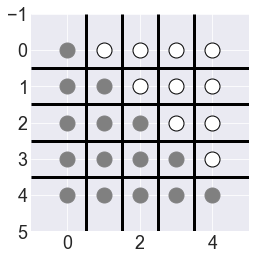

In [41]:
i, j = np.indices((5, 5))
x = np.vstack([i.flatten(), j.flatten()]).T
y = (x[:, 0] >= x[:, 1]).astype(int).reshape((-1, 1))
clf.fit(x, y)
fig, ax = plt.subplots()
ax.axis((-1, 5, -1, 5))
ax.set_aspect(1)
ax.invert_yaxis()

ax.plot(
    ma.masked_array(x[:, 1], y == 1),
    ma.masked_array(x[:, 0], y == 1),
    'ow',
    mec='k',
    ms=15)
ax.plot(
    ma.masked_array(x[:, 1], y == 0),
    ma.masked_array(x[:, 0], y == 0),
    'o',
    color='gray',
    ms=15)

for i, j in zip(clf.tree_.feature, clf.tree_.threshold):
    if i == 1:
        ax.hlines(j, -1, 6, lw=3.)
    else:
        ax.vlines(j, -1, 6, lw=3.)

<!-- dom:FIGURE: [fig-machine_learning/example_tree_004.png, width=500
frac=0.75]  The decision tree fitted to this triangular matrix is very complex,
as shown by the number of horizontal and vertical partitions. Thus, even though
the pattern in the training data is visually clear, the decision tree cannot
automatically uncover it. <div id="fig:example_tree_004"></div> -->
<!-- begin figure -->
<div id="fig:example_tree_004"></div>

<p>The decision tree fitted to this triangular matrix is very complex, as shown
by the number of horizontal and vertical partitions. Thus, even though the
pattern in the training data is visually clear, the decision tree cannot
automatically uncover it.</p>
<img src="fig-machine_learning/example_tree_004.png" width=500>

<!-- end figure -->


[Figure](#fig:example_tree_004) shows another example, but now using a simple
triangular matrix.  As shown by the number of vertical and horizontal
partitioning lines, the decision tree that corresponds to this figure is tall
and complex. Notice that if we apply a simple rotational transform to the
training data, we can obtain [Figure](#fig:example_tree_005), which requires a
trivial decision tree to fit. Thus, there may be transformations of the
training data that simplify the decision tree, but these are very difficult to
derive in general. Nonetheless, this highlights a key weakness of decision
trees wherein they may be easy to understand, to train, and to deploy, but may
be completely blind to such time-saving and complexity-saving transformations.
Indeed, in higher dimensions, it may be impossible to even visualize the
potential of such latent transformations.  Thus, the advantages of decision
trees can be easily outmatched by other methods that we will study later that
*do* have the ability to uncover useful transformations, but which will
necessarily be harder to train.  Another disadvantage is that because of how
decision trees are built, even a single misplaced data point can cause the tree
to grow very differently. This is a symptom of high variance.

In all of our examples, the decision tree was able to memorize the training
data exactly, as we discussed earlier, this is a sign of potential
generalization errors.  There are pruning algorithms that strategically remove
some of the deepest nodes. but these are not yet fully implemented in
Scikit-learn, as of this writing. Alternatively, restricting the maximum depth
of the decision tree can have a similar effect. The `DecisionTreeClassifier`
and `DecisionTreeRegressor` in Scikit-learn both have keyword arguments that
specify maximum depth.

## Random Forests

It is possible to combine a set of decision trees into a larger
composite tree that has better performance than its individual
components by using ensemble learning. This is implemented in
Scikit-learn as `RandomForestClassifier`.  The composite tree helps
mitigate the primary weakness of decision trees --- high variance.
Random forest classifiers help by averaging out the predictions of
many constituent trees to minimize this variance by randomly selecting
subsets of the training set to train the  embedded trees.   On the
other hand, this randomization can increase bias because there may be
a subset of the training set that yields an excellent decision tree,
but the averaging effect over randomized training samples washes this
out in the same averaging that reduces the variance. This is a key
trade-off.  The following code implements a simple random forest
classifer from our last example.

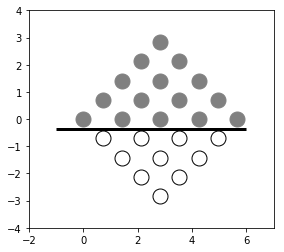

In [17]:
from numpy import sin, cos, pi
rotation_matrix=np.matrix([[cos(pi/4),-sin(pi/4)],
                           [sin(pi/4),cos(pi/4)]])
xr=(rotation_matrix*(x.T)).T
xr=np.array(xr)

fig,ax=subplots()
ax.set_aspect(1)
_=ax.axis(xmin=-2,xmax=7,ymin=-4,ymax=4)

_=ax.plot(ma.masked_array(xr[:,1],y==1),ma.masked_array(xr[:,0],y==1),'ow',mec='k',ms=15)
_=ax.plot(ma.masked_array(xr[:,1],y==0),ma.masked_array(xr[:,0],y==0),'o',color='gray',ms=15)

_=clf.fit(xr,y)

for i,j in zip(clf.tree_.feature,clf.tree_.threshold):
    if i==1:
        _=ax.vlines(j,-1,6,lw=3.)
    elif i==0:
        _=ax.hlines(j,-1,6,lw=3.)


<!-- dom:FIGURE: [fig-machine_learning/example_tree_005.png, width=500
frac=0.75] Using a simple rotation on the training data in
[Figure](#fig:example_tree_004), the decision tree can now easily fit the
training data with a single partition. <div id="fig:example_tree_005"></div> -->
<!-- begin figure -->
<div id="fig:example_tree_005"></div>

<p>Using a simple rotation on the training data in
[Figure](#fig:example_tree_004), the decision tree can now easily fit the
training data with a single partition.</p>
<img src="fig-machine_learning/example_tree_005.png" width=500>

<!-- end figure -->

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split, cross_val_score

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=1)
clf = tree.DecisionTreeClassifier(max_depth=2)
clf.fit(X_train, y_train)

rfc = RandomForestClassifier(n_estimators=4, max_depth=2)
rfc.fit(X_train, y_train.flat)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=4, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [53]:
clf.score(X_test,y_test),rfc.score(X_test,y_test)

(0.8571428571428571, 0.7142857142857143)

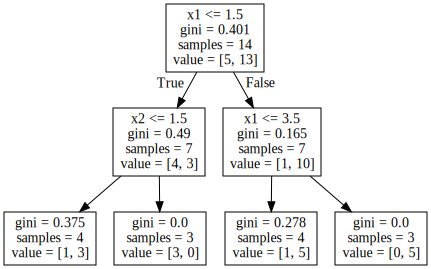

In [66]:
Source(tree.export_graphviz(rfc.estimators_[3], out_file=None, feature_names=['x1','x2']))

In [19]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=4,max_depth=2)
rfc.fit(X_train,y_train.flat)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=4, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [43]:
def draw_board(x,y,clf,ax=None):
    if ax is None: fig,ax=subplots()
    xm,ymn=x.min(0).T
    ax.axis(xmin=xm-1,ymin=ymn-1)
    xx,ymx=x.max(0).T
    ax.axis(xmax=xx+1,ymax=ymx+1)
    ax.set_aspect(1)
    ax.invert_yaxis()
    ax.plot(ma.masked_array(x[:,1],y==1),ma.masked_array(x[:,0],y==1),'ow',mec='k')
    ax.plot(ma.masked_array(x[:,1],y==0),ma.masked_array(x[:,0],y==0),'o',color='gray')
    for i,j in zip(clf.tree_.feature,clf.tree_.threshold):
        if i==1:
            ax.vlines(j,-1,6,lw=3.)
        elif i==0:
            ax.hlines(j,-1,6,lw=3.)
    return ax

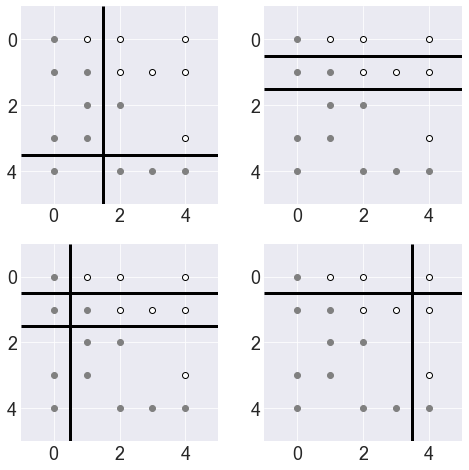

In [45]:
fig,axs = plt.subplots(2,2,figsize=(8,8))
# draw constituent decision trees
for est,ax in zip(rfc.estimators_,axs.flat):
    draw_board(X_train,y_train,est,ax=ax)


Note that we have constrained the maximum depth `max_depth=2` to help
with generalization. To keep things simple we have only set up a forest with
four individual classifers [^seedNote].  [Figure](#fig:example_tree_006) shows
the individual classifers in the forest that have been trained above. Even
though all the constituent decision trees share the same training data, the
random forest  algorithm randomly picks feature subsets (with replacement) upon
which to train individual trees. This helps avoid the tendency of decision
trees to become too deep and lopsided, which hurts both performance and
generalization. At the prediction step, the individual outputs of each of the
constituent decision trees are put to a majority vote for the final
classification. To estimate generalization errors without using
cross-validation, the training elements *not* used for a particular constituent
tree can be used to test that tree and form a collaborative estimate of
generalization errors.  This is called the *out-of-bag* estimate.

[^seedNote]: We have also set the random seed to a fixed value
to make the figures reproducible in the IPython Notebook corresponding to
this section.

<!-- dom:FIGURE: [fig-machine_learning/example_tree_006.png, width=500
frac=0.85] The constituent decision trees of the random forest and how they
partitioned the training set are shown in these four panels. The random forest
classifier uses the individual outputs of each of the constituent trees to
produce a collaborative  final estimate. <div id="fig:example_tree_006"></div>
-->
<!-- begin figure -->
<div id="fig:example_tree_006"></div>

<p>The constituent decision trees of the random forest and how they partitioned
the training set are shown in these four panels. The random forest classifier
uses the individual outputs of each of the constituent trees to produce a
collaborative  final estimate.</p>
<img src="fig-machine_learning/example_tree_006.png" width=500>

<!-- end figure -->


The main advantage of random forest classifiers is that they require very
little tuning and provide a way to trade-off bias and variance via averaging
and randomization. Furthermore, they are fast and easy to train in parallel
(see the `n_jobs` keyword argument) and fast to predict. On the downside, they
are less interpretable than simple decision trees.  There are many other
powerful tree methods in Scikit-learn like `ExtraTrees` and Gradient Boosted
Regression Trees `GradientBoostingRegressor` which are discussed in the online
documentation.